### Wiener Filters

In this notebook, we will explore Wiener filters in the time domain using some generated/recorded audio signals. 


Firstly let us import several of the packages we will need. If these packages are not available on your machine, you will have to install them first. 

In [33]:
import numpy as np 
import scipy as sp
from scipy import signal
import sounddevice as sd
import soundfile as sf
from matplotlib import pyplot as plt
import IPython
from IPython.display import Audio, Image
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML('<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.'))

### Setting up the problem

Consider that we have the following signals:

1. A desired signal, $\mathbf{x}$ = [x(0) x(1) x(2) ... x(N-1)]$^T$
2. An input signal, $\mathbf{\bar{y}}$ = [y(0) y(1) y(2) ... y(N-1)]$^T$

where N is the length of the signals. Our goal is that we want to design some "optimal" filter to filter the input signal such that it is as similar as possible to $x[n]$. So how do we do that and what is a Wiener filter?

Well let's firstly start by defining a filter with $P$ coefficients, where $P < N$:

Optimal Filter: $\mathbf{w}$ = [w(0) w(1) w(2) ... w(P)]$^T$

Now we can compute the m$^{th}$ sample of the filtered input signal as follows:
\begin{align}
\hat{x}(m) &= \sum_{k=0}^{P} \mathrm{w}(k) \mathrm{y}(m-k) \\
            &= \mathrm{[w(0) \hspace{0.1cm} w(1) \hspace{0.1cm} w(2)\hspace{0.1cm}  ... \hspace{0.1cm} w(P)]} \begin{bmatrix} y(m) \\ y(m-1) \\ y(m-2) \\ \vdots \\ y(m-(P-1))\\ \end{bmatrix}\\
            & = \mathbf{w}^{T} \mathbf{y}
\end{align}

which we can recognise as a convolution between the optimal filter and the input signal. This filtered input signal, $\hat{x}$ (pronounced x-hat) is what we refer to as an **estimate** of our input signal.

Okay, so back to the question - how do we design this filter? Well for each sample we can observe the difference or error between the desired, $x(m)$ and its estimate $\hat{x}(m)$, which can be a first indicator as to how well our estimate approximates the desired signal. However, a better option would be to observe such an error in a more statistical sense by what is called the mean-squared error (MSE), which is defined as follows: 

\begin{equation}
MSE = \mathbb{E}\{e^{2}(m)\} = \mathbb{E}\{(x(m) - \hat{x}(m))^{2}\} = \mathbb{E}\{(x(m) - \mathbf{w}^{T} \mathbf{y})^{2}\}
\end{equation}

where $\mathbb{E}$ is the expectation operator. In other words, the MSE is the expected or average squared error between the input and its estimate. We use the squared-error as opposed to just the error because many times we use signals with zero-mean, and hence we are not able to distinguish if a zero error would come from the zero mean of the signals or if the signals are really that similar. Therefore we can say that if the MSE between two signals is small, this corresponds to the two signals being more similar. 

This is precisely the criterion under which the Wiener filter is designed. The Wiener filter is an optimal filter which **minimises** the MSE between the desired signal and its estimate. The cost function for computing the Wiener filter is then given by:

\begin{equation}
\underset{\mathbf{w}}{\text{minimize}} \hspace{0.2cm} \mathbb{E}\{(x(m) - \mathbf{w}^{T} \mathbf{y})^{2}\}
\end{equation}

From the SPAI course, you also know that the Wiener filter is then given by:
\begin{equation}
\mathbf{w} = \mathbf{R}^{-1}_{yy} \mathbf{r}_{yx} 
\end{equation}

where $\mathbf{R}_{yy}$ is the autocorrelation matrix of the input signal and $\mathbf{r}_{yx}$ is the cross-correlation vector between the input and the desired signal. (Later on we will elaborate on these equations).
It should also be apparent here why we are also calling these optimal filters. We have defined a mathematically tractable criterion under which we want to tdesign the filters and found an "optimum" solution to the cost function, i.e. by finding the filter coefficients which resulted in the minimum MSE. 





### Wiener filtering a distorted, noisy signal in an attempt to retrieve the desired signal.

In the demo that follows, we firstly create a desired signal, which will be a simple sine wave. We then play this sine wave through the loudspeaker of our computer and record it with the microphone. Essentially what we would have done is introduced some linear distortion and noise to our desired signal.

The question is now - can we design a Wiener filter that can be applied to the recorded microphone signal so that we can get back to the desired signal? 

Let's find out!


First up, let's create our desired signal. We use low sampling frequencies to keep the computations manageable. 

Number of samples = 12000


<IPython.core.display.Javascript object>


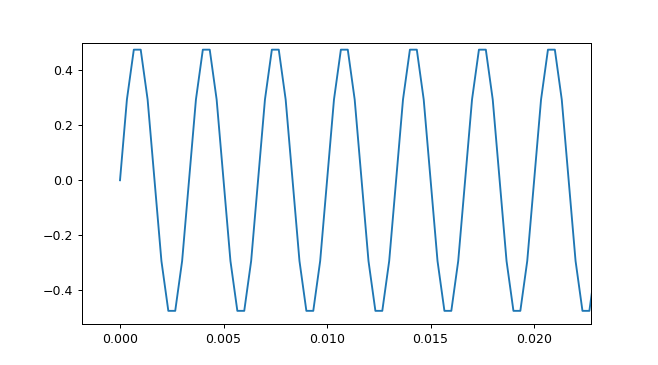

In [34]:
# Create a desired signal

T = 4  # time duration (seconds)
fs = 3000    # Sampling frequency (Hz)
t = np.arange(0, T, 1/fs)
fo = 300
x_init = 0.5*np.sin(2*np.pi*fo*t)  # will truncate later
N_init = len(x_init)
print ('Number of samples = '+str(N_init))
IPython.display.display(Audio(x_init, rate=fs, normalize=False))

fig, axes = plt.subplots(figsize=(4, 2)) 
axes.plot(t,x_init)


# Uncomment this if you want to see the spectrum
# # Signal spectrum
# Xf = np.fft.fft(x,axis=0)  
# Xfss = Xf[0:N//2+1]  # Single sided spectrum. The last value will be N/2, since python goes up to N-1 when slicing vectors like this.

# #Set up the frequency vector
# df = fs/N  # the frequency bin spacing
# freqs = np.arange(0,fs/2 + df,df) # first value = DC, last value = fs/2

# # Magnitude-Squared

# fig, axes = plt.subplots(figsize=(4, 2)) 
# axes.plot(freqs[0:N//2+1],np.abs(Xfss**2))
# # axes.set_yscale('log')  # toggle this to check out a log y-axis
# axes.set_title('FFT of Impulse Response')
# axes.set_xlabel('Frequency (Hz)')
# axes.set_ylabel('Magnitude-Squared of FFT coefficients')

In [35]:
# Recording the desired signal as it propagates through the channel

# Use autoplay to play generated signal
print('x: ')
IPython.display.display(Audio(x_init.T, rate=fs,autoplay=True,normalize=False)) # play autoplay signal to record

print ('recording x ...')
y_init = sd.rec(T*fs, blocking=True,samplerate=fs, channels=1)
print ('finished recording')



x: 


recording x ...
finished recording


Data shape:  (12000, 1)
Recorded Signal:


<IPython.core.display.Javascript object>


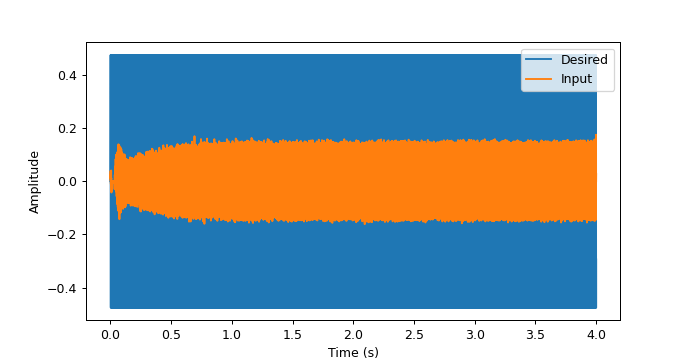

In [36]:
print("Data shape: ", y_init.shape)
print("Recorded Signal:")
IPython.display.display(Audio(y_init.T, rate=fs))

fig, axes = plt.subplots(figsize=(4, 2)) 

axes.plot(t,x_init, label = 'Desired')
axes.plot(t,y_init, label = 'Input')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amplitude')
axes.legend()

Okay, so we can clearly see and hear the distorted, noisy sinusoid. Due to the way python does the recording, there are also some artifacts introduced in the very beginning and ending of the recording, so let us just use the section in the middle where things appear more stationary. You can try with and without removing these sections to also observe the performance, but let's redefine the input and output signal as follows by truncating a second from the beginning and a second from the end.


<IPython.core.display.Javascript object>


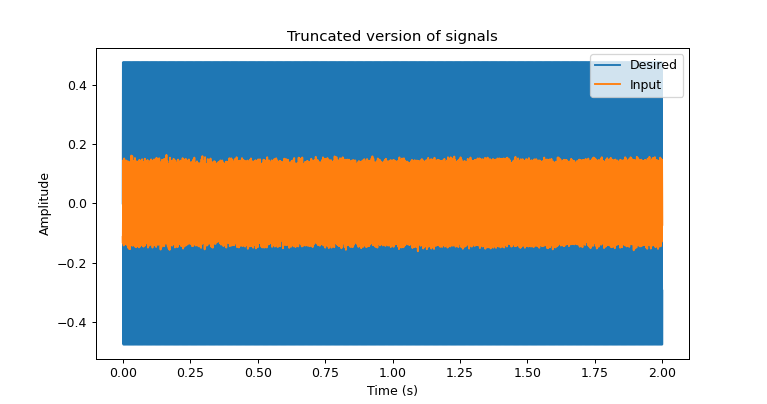

In [37]:
st_time = np.round(1*fs)
end_time = np.round(3*fs)
x = x_init[st_time:end_time]
y = y_init[st_time:end_time]
N = len(y)

# Create new time variable:
t = np.arange(0, N//fs, 1/fs)

fig, axes = plt.subplots(figsize=(4, 2)) 

axes.plot(t,x, label = 'Desired')
axes.plot(t,y, label = 'Input')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amplitude')
axes.set_title('Truncated version of signals')
axes.legend()




### Observing the convolution matrices

In the following, we firstly observe the system of equations obtained when stacking the error signal for all samples. Recall that for the m$^{th}$ sample, we could express the error as follows:

\begin{align}
e(m) &= x(m) - \hat{x}(m) \\
    & = x(m) -  \mathrm{[w(0) \hspace{0.1cm} w(1) \hspace{0.1cm} w(2)\hspace{0.1cm}  ... \hspace{0.1cm} w(P)]} \begin{bmatrix} y(m) \\ y(m-1) \\ y(m-2) \\ \vdots \\ y(m-(P-1))\\ \end{bmatrix} 
\end{align}

Stacking these samples together we get the following:

\begin{align}
\begin{bmatrix} \hat{x}(0) \\ \hat{x}(1) \\ \hat{x}(2) \\ \vdots \\ \hat{x}(N-1))\\ \end{bmatrix}  & =  \begin{bmatrix} y(0)  & y(-1) & \dots & y(1-P)  \\  y(1)  & y(0) & \dots & y(2-P) \\  y(2)  & y(1) & \dots & y(3-P) \\  \vdots  & \vdots & \ddots & \vdots \\  y(N-1)  & y(N-2) & \dots & y(N-P)\\ \end{bmatrix} \begin{bmatrix} \mathrm{w}(0) \\ \mathrm{w}(1) \\ \vdots \\ \mathrm{w}(P-1)\\ \end{bmatrix} \\
\\
\mathbf{\hat{x}} &= \mathbf{Y}\mathbf{w}
\end{align}

In the following, we firstly choose the number of coefficients for the Wiener filter, P.
We then construct the convolution matrix $\mathbf{Y}$ (which is toeplitz) and observe a few of the rows. 

In [40]:
# Select a value for P

P = 5

# Create toeplitz matrix for Y
row1 = np.r_[y[0], np.zeros(P-1)]  # first row in toeplitz matrix
col1 = np.r_[y] # first column in toeplitz matrix
Y = sp.linalg.toeplitz(col1, row1)  # Toeplitz matrix
print ('Dimension of Y = '+str(Y.shape))

# We can check out a few rows of Y to see how it looks (note that the first few rows may be equal to zero).
# Can compare to the corresponding value of x

row_number = 103
print('Row '+str(row_number) + ' of Y: '+str(Y[row_number,:]))
print('Sample '+str(row_number)+ ' of x: '+str(x[row_number]))

# fig, axes = plt.subplots(figsize=(2, 4)) 
# axes.spy(Y,aspect='auto') # spy plots a sparse matrix - dark colours when there is data, white when none.
# axes.set_title('convolution matrix Y')
# axes.set_xlabel('P')
# axes.set_ylabel('N')


Dimension of Y = (6000, 5)
Row 103 of Y: [-0.02929616 -0.10577597 -0.14123848 -0.11939144 -0.06138678]
Sample 103 of x: 0.47552825814760225


### Construting autocorrelation matrices and cross-correlation vector

Recall that the optimal Wiener filter is given as follows:
\begin{equation}
\mathbf{w} = \mathbf{R}^{-1}_{yy} \mathbf{r}_{yx},
\end{equation}

where $\mathbf{R}_{yy} = \mathbb{E} \{ \mathbf{y y}^{\mathit{T}} \}$ is the autocorrelation matrix of dimension $(P \times P)$, and $\mathbf{r}_{yx} = \mathbb{E} \{ \mathbf{y}x \}$ is the cross-correlation vector of dimension P. The elements of $\mathbf{R}_{yy}$ are given by the autocorrelation function, $r_{yy}(k) = \mathbb{E} \{y(m) y(m+k) \}$ for the m$^{th}$ sample at lag k.

Hence the previous equation can be expanded as follows:

\begin{align}
\begin{bmatrix} \mathrm{w}(0) \\ \mathrm{w}(1) \\ \vdots \\ \mathrm{w}(P-1)\\ \end{bmatrix}  & =  \begin{bmatrix} r_{yy}(0)  & r_{yy}(1) & \dots & r_{yy}(P-1)  \\ r_{yy}(1)  & r_{yy}(0) & \dots & r_{yy}(P-2) \\  \vdots  & \vdots & \ddots & \vdots \\ r_{yy}(P-1)  & r_{yy}(P-2) & \dots & r_{yy}(0)\\ \end{bmatrix}^{-1} \begin{bmatrix} {r}_{yx}(0) \\ {r}_{yx}(1) \\ \vdots \\ {r}_{yx}(P-1)\\ \end{bmatrix} \\
\\
\end{align}

In practice, the question is how should one estimate  $\mathbf{R}_{yy}$ and $\mathbf{r}_{yx}$. One option is to average over an ensemble of different realizations of desired/observed signals. Another option, in particular for correlation-ergodic processes (i.e. the single realisation must be representative of the entire process see here: https://en.wikipedia.org/wiki/Ergodic_process), ensemble averaging can be replaced by time averaging so only 1 realization needed. We will use the latter of these methods in the following. 

Hence we compute $r_{yy}(k)$ and $r_{yx}(k)$ as follows:

\begin{align}
r_{yy}(k) &= \frac{1}{N} \sum_{m=0}^{N-1} y(m) y(m+k) \\
r_{yx}(k) &= \frac{1}{N} \sum_{m=0}^{N-1} y(m) x(m+k)
\end{align}

These values are then substituted into the equations above to solve for the Wiener filter. 

In [41]:
# The approach to doing the computations of ryy and ryx is as follows.
# For each time lag, k:
#     1. Advance the appropriate signal by lag k - this will be done using a circular shift
#     2. Zero out last k circularly shifted samples
#     3. Then perform the sum as an inner product between the unshifted and shifted version and avg.


ryy = np.zeros([P,1])
ryx = np.zeros([P,1])

for k in range(P):

    y_lag = np.roll(y,-k) # circular shift, note the -k here, it means we are advancing, i.e. (m+k) sample
    x_lag = np.roll(x,-k) 
    
    if k > 0:
        y_lag[-k:] = 0       # zero out last k values
        x_lag[-k:] = 0       
    
        
    ryy[k,0] = (1/N)*y_lag.T@y  # Inner products and average
    ryx[k,0] = (1/N)*x_lag.T@y
    

print('ryy: \n'+str(ryy))
    
# Create autocorrelation matrix Ryy
row1 = ryy.T  # first row in toeplitz matrix
col1 = ryy # first column in toeplitz matrix
Ryy = sp.linalg.toeplitz(col1, row1)  # Toeplitz matrix


print('Autocorrelation Matrix, Ryy: \n'+str(Ryy))
print('Cross-correlation vector ryx: \n'+str(ryx))



# Solve the system of linear equations
# Use scipy.linalg.solve for solving systems of eqns
w = sp.linalg.solve(Ryy, ryx, assume_a='sym')

print('Optimal Wiener Filter: \n'+str(w))



ryy: 
[[ 0.01052183]
 [ 0.0084962 ]
 [ 0.00324288]
 [-0.00323126]
 [-0.00846749]]
Autocorrelation Matrix, Ryy: 
[[ 0.01052183  0.0084962   0.00324288 -0.00323126 -0.00846749]
 [ 0.0084962   0.01052183  0.0084962   0.00324288 -0.00323126]
 [ 0.00324288  0.0084962   0.01052183  0.0084962   0.00324288]
 [-0.00323126  0.00324288  0.0084962   0.01052183  0.0084962 ]
 [-0.00846749 -0.00323126  0.00324288  0.0084962   0.01052183]]
Cross-correlation vector ryx: 
[[-0.01553821]
 [-0.03177529]
 [-0.03587176]
 [-0.02626734]
 [-0.00663494]]
Optimal Wiener Filter: 
[[-0.0312873 ]
 [-1.47981169]
 [-1.30551373]
 [-1.21913823]
 [ 0.27658224]]


### Filter the input signal with the Wiener filter


Input, y:


Desired, x:


Estimate, x_hat:


Error signal, error:


MSE = 0.00046969086521525625


<IPython.core.display.Javascript object>


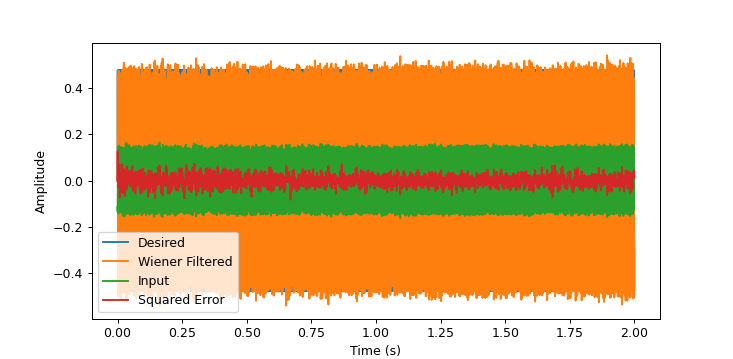

In [44]:
w_rand = np.random.rand(P,1) # Replace w below with w_rand and see what happens

x_hat = Y@w  # signal estimate
error = (x-x_hat[:,0]) # error between both signals
MSE = (1/N)*np.sum(error**2) # Mean-sqaured error between both signals


print("Input, y:")
IPython.display.display(Audio(y.T, rate=fs,normalize=False))

print("Desired, x:")
IPython.display.display(Audio(x.T, rate=fs,normalize=False))

print("Estimate, x_hat:")
IPython.display.display(Audio(x_hat.T, rate=fs,normalize=False))

print("Error signal, error:")
IPython.display.display(Audio(error.T, rate=fs,normalize=False))

print("MSE = "+str(MSE))


fig, axes = plt.subplots(figsize=(4, 2)) 

axes.plot(t,x,label='Desired')
axes.plot(t,x_hat,label='Wiener Filtered')
axes.plot(t,y,label='Input')
axes.plot(t,error,label='Squared Error')

axes.set_xlabel('Time (s)')
axes.set_ylabel('Amplitude')
axes.legend()



### Something for you to try or think about.

In this notebook, we tried to estimate the desired signal. 
If alternatively we wanted to estimate the parameters that produced the distorted desired signal, how would we change things to accomplish this? Such a task is typically useful for applications such as echo/feedback control, where we would like to estimate the filter coefficients that correspond to the path between a loudspeaker and a microphone. 